In [25]:
# ============================================================
# 0. SETUP
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost (install if needed: pip install xgboost)
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


In [26]:
# ============================================================
# 1. LOAD FEATURE-ENGINEERED DATA
# ============================================================

# Option 1: Load combined df with target inside
# df_model = pd.read_csv("car_sales_feature_engineered.csv")

# Option 2: Load X and y separately (from previous notebook)
# X = pd.read_csv("X_features.csv")
# y = pd.read_csv("y_target_price.csv").squeeze()  # squeeze to convert to Series

# FIX: X_features.csv and y_target_price.csv were not found.
# Loading car_sales_data.csv and separating features (X) and target (y)
# Assuming 'Price' is the target variable based on the original commented-out code mentioning 'y_target_price.csv'.
df = pd.read_csv("car_sales_data.csv")
y = df['Price'].squeeze()
X = df.drop('Price', axis=1)

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Manufacturer', 'Model', 'Fuel type'], drop_first=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()

X shape: (50000, 23)
y shape: (50000,)


,Engine size,Year of manufacture,Mileage,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW,Model_911,Model_Cayenne,Model_Fiesta,Model_Focus,Model_Golf,Model_M5,Model_Mondeo,Model_Passat,Model_Polo,Model_Prius,Model_RAV4,Model_X3,Model_Yaris,Model_Z4,Fuel type_Hybrid,Fuel type_Petrol
0,1.0000,2002,127300,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,4.0000,2016,57850,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,1.6000,2014,39190,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,1.8000,1988,210814,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
4,1.0000,2006,127869,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [27]:
# ============================================================
# 2. TRAIN-TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 40000
Test set size: 10000


In [28]:
# ============================================================
# 3. DEFINE MODELS FOR H1
# ============================================================
# Hypothesis H1:
# "XGBoost will outperform Linear Regression and Random Forest
#  in predicting car prices."

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="reg:squarederror",
        n_jobs=-1
    )
}

models


{'LinearRegression': LinearRegression(),
 'RandomForest': RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)}

In [29]:
# ============================================================
# 4. CROSS-VALIDATION EVALUATION FUNCTION
# ============================================================

from sklearn.model_selection import KFold

def evaluate_model_cv(model, X, y, cv_splits=5):
    """
    Evaluate a regression model with cross-validation using:
    - RMSE
    - MAE
    - R2
    Returns dict with mean scores.
    """
    scoring = {
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2"
    }

    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    mean_rmse = -cv_results["test_rmse"].mean()
    mean_mae = -cv_results["test_mae"].mean()
    mean_r2 = cv_results["test_r2"].mean()

    return {
        "RMSE": mean_rmse,
        "MAE": mean_mae,
        "R2": mean_r2
    }


In [30]:
# ============================================================
# 5. RUN CROSS-VALIDATION FOR ALL MODELS
# ============================================================

results = []

for name, model in models.items():
    print(f"Evaluating {name} ...")
    scores = evaluate_model_cv(model, X, y, cv_splits=5)
    scores["Model"] = name
    results.append(scores)

results_df = pd.DataFrame(results)
results_df = results_df[["Model", "RMSE", "MAE", "R2"]]
results_df.sort_values("RMSE", inplace=True)

print("\nCross-validated performance (lower RMSE/MAE is better, higher R² is better):")
results_df


Evaluating LinearRegression ...
Evaluating RandomForest ...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Evaluating XGBoost ...

Cross-validated performance (lower RMSE/MAE is better, higher R² is better):


,Model,RMSE,MAE,R2
2,XGBoost,322.4065,191.7793,0.9996
1,RandomForest,639.9038,285.6624,0.9985
0,LinearRegression,"8,767.7538","5,766.5057",0.7147


In [31]:
# ============================================================
# 6. FIT MODELS ON TRAIN DATA & EVALUATE ON TEST DATA
# ============================================================

test_results = []

for name, model in models.items():
    print(f"Training {name} on train set...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Fix: remove 'squared=False' if scikit-learn version is older and calculate RMSE manually.
    # mean_squared_error(y_test, y_pred) returns MSE by default.
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    test_results.append({
        "Model": name,
        "RMSE_test": rmse_test,
        "MAE_test": mae_test,
        "R2_test": r2_test
    })

test_results_df = pd.DataFrame(test_results).sort_values("RMSE_test")
print("\nTest set performance:")
test_results_df

Training LinearRegression on train set...
Training RandomForest on train set...
Training XGBoost on train set...

Test set performance:


,Model,RMSE_test,MAE_test,R2_test
2,XGBoost,304.9707,188.3249,0.9997
1,RandomForest,647.1079,292.8877,0.9985
0,LinearRegression,"8,868.2607","5,786.3131",0.7102


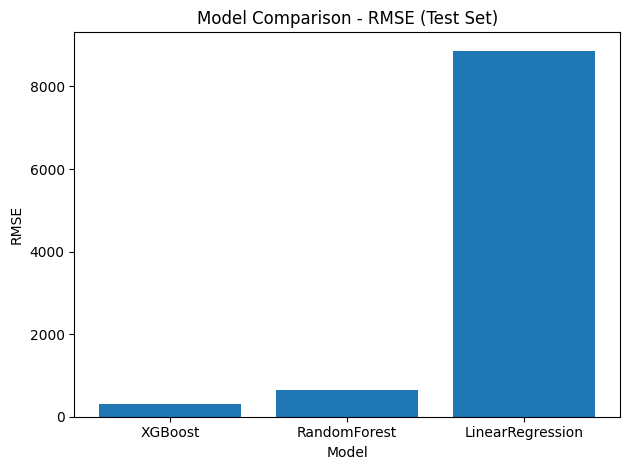

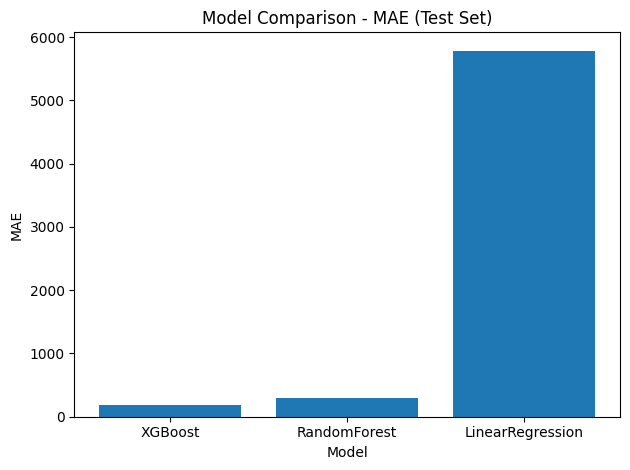

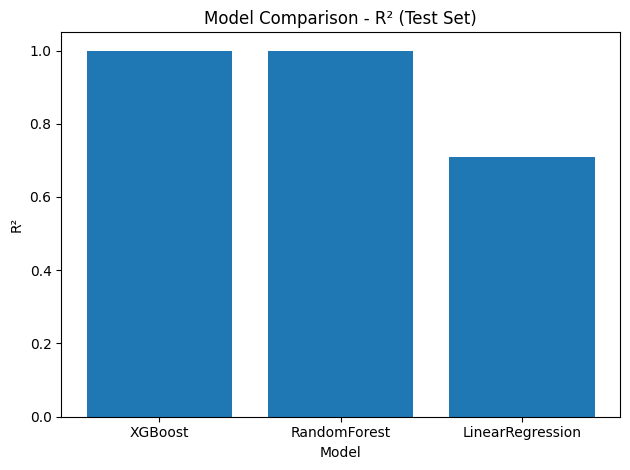

In [32]:
# ============================================================
# 7. VISUALIZE MODEL COMPARISON (TEST SET)
# ============================================================

# RMSE comparison
plt.figure()
plt.bar(test_results_df["Model"], test_results_df["RMSE_test"])
plt.title("Model Comparison - RMSE (Test Set)")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# MAE comparison
plt.figure()
plt.bar(test_results_df["Model"], test_results_df["MAE_test"])
plt.title("Model Comparison - MAE (Test Set)")
plt.ylabel("MAE")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# R2 comparison
plt.figure()
plt.bar(test_results_df["Model"], test_results_df["R2_test"])
plt.title("Model Comparison - R² (Test Set)")
plt.ylabel("R²")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [33]:
# ============================================================
# 8. FEATURE IMPORTANCE (RANDOM FOREST & XGBOOST)
# ============================================================

# Refit best models if needed (we already fitted them in step 6)
rf_model = models["RandomForest"]
xgb_model = models["XGBoost"]

# Get feature names
feature_names = X.columns

# Random Forest importance
rf_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_importances
}).sort_values("Importance", ascending=False)

print("Top 15 Random Forest feature importances:")
rf_importance_df.head(15)


Top 15 Random Forest feature importances:


,Feature,Importance
1,Year of manufacture,0.6193
0,Engine size,0.2605
2,Mileage,0.0392
7,Model_911,0.0210
12,Model_M5,0.0208
22,Fuel type_Petrol,0.0095
17,Model_RAV4,0.0087
4,Manufacturer_Porsche,0.0050
5,Manufacturer_Toyota,0.0018
6,Manufacturer_VW,0.0018


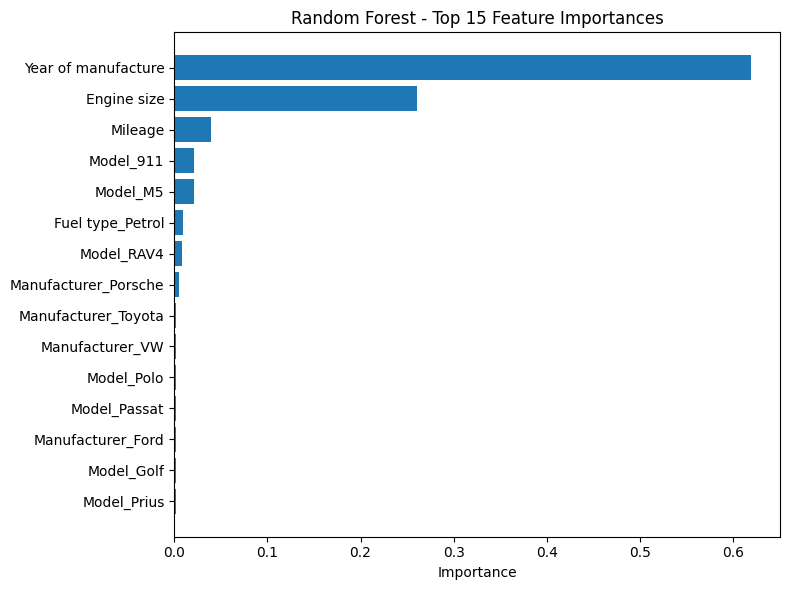

In [34]:
# Plot RF importances (top 15)
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(rf_importance_df["Feature"].head(top_n)[::-1],
         rf_importance_df["Importance"].head(top_n)[::-1])
plt.title("Random Forest - Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [35]:
# XGBoost importance
xgb_importances = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_importances
}).sort_values("Importance", ascending=False)

print("Top 15 XGBoost feature importances:")
xgb_importance_df.head(15)


Top 15 XGBoost feature importances:


,Feature,Importance
12,Model_M5,0.3394
4,Manufacturer_Porsche,0.1507
1,Year of manufacture,0.1201
0,Engine size,0.0804
7,Model_911,0.0629
17,Model_RAV4,0.0523
2,Mileage,0.0488
15,Model_Polo,0.0219
9,Model_Fiesta,0.0206
5,Manufacturer_Toyota,0.0191


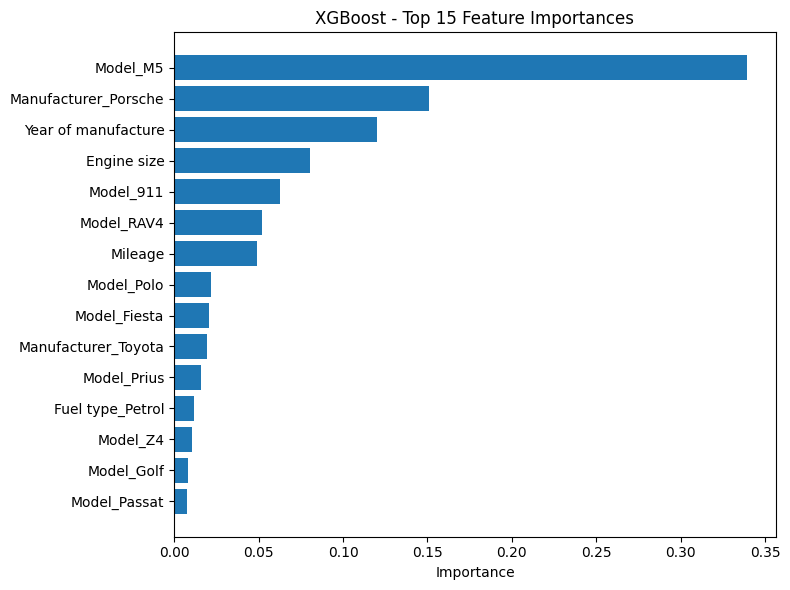

In [36]:
# Plot XGBoost importances (top 15)
plt.figure(figsize=(8, 6))
plt.barh(xgb_importance_df["Feature"].head(top_n)[::-1],
         xgb_importance_df["Importance"].head(top_n)[::-1])
plt.title("XGBoost - Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [37]:
# ============================================================
# 9. SAVE RESULTS FOR THESIS
# ============================================================

results_df.to_csv("H1_model_comparison_cv.csv", index=False)
test_results_df.to_csv("H1_model_comparison_test.csv", index=False)

print("Saved:")
print("  - H1_model_comparison_cv.csv")
print("  - H1_model_comparison_test.csv")


Saved:
  - H1_model_comparison_cv.csv
  - H1_model_comparison_test.csv


In [38]:
# ============================================================
# 10. QUICK TEXT SUMMARY FOR H1 (FILL IN AFTER SEEING RESULTS)
# ============================================================

print("=== H1 MODEL SUMMARY (TO WRITE IN THESIS) ===")

print("\n1) Cross-validated results (5-fold):")
print(results_df)

print("\n2) Test set results:")
print(test_results_df)

print("\nInterpretation guide:")
print("- Check which model has the LOWEST RMSE and MAE and HIGHEST R².")
print("- If XGBoost is best, H1 is supported.")
print("- If RandomForest or LinearRegression wins, H1 is rejected or partially supported.")


=== H1 MODEL SUMMARY (TO WRITE IN THESIS) ===

1) Cross-validated results (5-fold):
              Model       RMSE        MAE     R2
2           XGBoost   322.4065   191.7793 0.9996
1      RandomForest   639.9038   285.6624 0.9985
0  LinearRegression 8,767.7538 5,766.5057 0.7147

2) Test set results:
              Model  RMSE_test   MAE_test  R2_test
2           XGBoost   304.9707   188.3249   0.9997
1      RandomForest   647.1079   292.8877   0.9985
0  LinearRegression 8,868.2607 5,786.3131   0.7102

Interpretation guide:
- Check which model has the LOWEST RMSE and MAE and HIGHEST R².
- If XGBoost is best, H1 is supported.
- If RandomForest or LinearRegression wins, H1 is rejected or partially supported.
